# Exploratory Data Analysis

This notebook is heavly based on https://www.kaggle.com/ekhtiar/finding-pneumo-part-1-eda-and-unet

In [1]:
import os
import gc
import time
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

os.chdir(os.path.dirname("../src/"))

In [2]:
import torch
import torch.optim as optim

# Set seeds for reproducibility
SEED=0
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
import cv2
import pydicom

In [4]:
from siim_pneumothorax.utils import run_length_decode

In [5]:
# Constants
root = "../data/siim/dicom-images-train/"

# Data Preparation

In [6]:
train_fns = sorted(glob('../data/siim/dicom-images-train/*/*/*.dcm'))
test_fns = sorted(glob('../data/siim/dicom-images-test/*/*/*.dcm'))

In [7]:
train_rle_codes = pd.read_csv('../data/siim/train-rle.csv')
train_rle_codes.columns = ["ImageId", "EncodedPixels"]
train_rle_codes['has_pneumothorax'] = (train_rle_codes.EncodedPixels != "-1").astype(int)

In [8]:
def parse_dicom(fn, rles_codes=None, is_training=True):
    dcm_info = pydicom.dcmread(fn)

    # Create a dictionary with pacient information (Except name)
    dcm_data = {
        'fn': fn,
        'user_id': dcm_info.PatientID,
        'user_age': int(dcm_info.PatientAge),
        'user_sex': dcm_info.PatientSex,
        'pixel_spacing': dcm_info.PixelSpacing,
        'id': dcm_info.SOPInstanceUID
    }

    # Get mask annotation
    if is_training:
        match = rles_codes[rles_codes['ImageId']==dcm_info.SOPInstanceUID]

        # get meaningful information (for train set)
        if len(match) == 0:
            dcm_data['EncodedPixels'] = np.nan
            dcm_data['has_pneumothorax'] = np.nan
        else:
            dcm_data['EncodedPixels'] = match['EncodedPixels'].values
            dcm_data['has_pneumothorax'] = np.max(match['has_pneumothorax'].values)

    return dcm_data

In [9]:
train_dataset = pd.DataFrame([parse_dicom(x, train_rle_codes) for x in  train_fns])

In [10]:
test_dataset = pd.DataFrame([parse_dicom(x, is_training=False) for x in  test_fns])

In [11]:
train_dataset.dropna(inplace=True)

# Visualization

In [12]:
samples = train_dataset[train_dataset.has_pneumothorax == 1].sample(4)

In [13]:
def plot_training_images(img_list, cmap=plt.cm.bone):
    for x in img_list.itertuples():
        img = pydicom.read_file(x.fn).pixel_array
        num_masks = len(x.EncodedPixels)
        masks_list = np.sum(np.array([run_length_decode(mask, 1024, 1024) for mask in x.EncodedPixels]), axis=0)
        masks_list[masks_list > 0] = 1
 
        # info
        age = x.user_age
        sex = x.user_sex
        pneumo = x.has_pneumothorax
        
        fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,10))
        
        # print the original xray
        ax[0].imshow(img, cmap=cmap)
        ax[0].set_title('Original X-ray')
        ax[0].text(200, 1024,
           'Age: {}, Sex: {}, Pneumothorax: {}'.format(age, sex, pneumo),
           size=18,color='white', backgroundcolor='black'
        )
        
        # print the mask to identify the region
        ax[1].imshow(img, cmap=cmap)
        ax[1].imshow(masks_list, alpha=0.5, cmap="Reds")
        ax[1].set_title('With Mask')
        ax[1].text(200, 1024,
           'Age: {}, Sex: {}, Pneumothorax: {}'.format(age, sex, pneumo),
           size=18, color='white', backgroundcolor='black'
        )
        plt.show()

In [23]:
def plot_training_images_CLAHE(img_list, cmap=plt.cm.bone):
    for x in img_list.itertuples():
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
        img = pydicom.read_file(x.fn).pixel_array
        img_filt = clahe.apply(img)
        num_masks = len(x.EncodedPixels)
        masks_list = np.sum(np.array([run_length_decode(mask, 1024, 1024) for mask in x.EncodedPixels]), axis=0)
        masks_list[masks_list > 0] = 1
 
        # info
        age = x.user_age
        sex = x.user_sex
        pneumo = x.has_pneumothorax
        
        fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,10))
        
        # print the original xray
        ax[0].imshow(img, cmap=cmap)
        ax[0].set_title('Original X-ray')
        ax[0].text(50, 1024,
           'Age: {}, Sex: {}, Pneumothorax: {}'.format(age, sex, pneumo),
           size=18,color='white', backgroundcolor='black'
        )
        
        # print the original xray
        ax[1].imshow(img_filt, cmap=cmap)
        ax[1].set_title('CLAHE X-ray')
        ax[1].text(50, 1024,
           'Age: {}, Sex: {}, Pneumothorax: {}'.format(age, sex, pneumo),
           size=18,color='white', backgroundcolor='black'
        )
        
        # print the mask to identify the region
        ax[2].imshow(img_filt, cmap=cmap)
        ax[2].imshow(masks_list, alpha=0.5, cmap="Reds")
        ax[2].set_title('With Mask')
        ax[2].text(50, 1024,
           'Age: {}, Sex: {}, Pneumothorax: {}'.format(age, sex, pneumo),
           size=18, color='white', backgroundcolor='black'
        )
        plt.show()

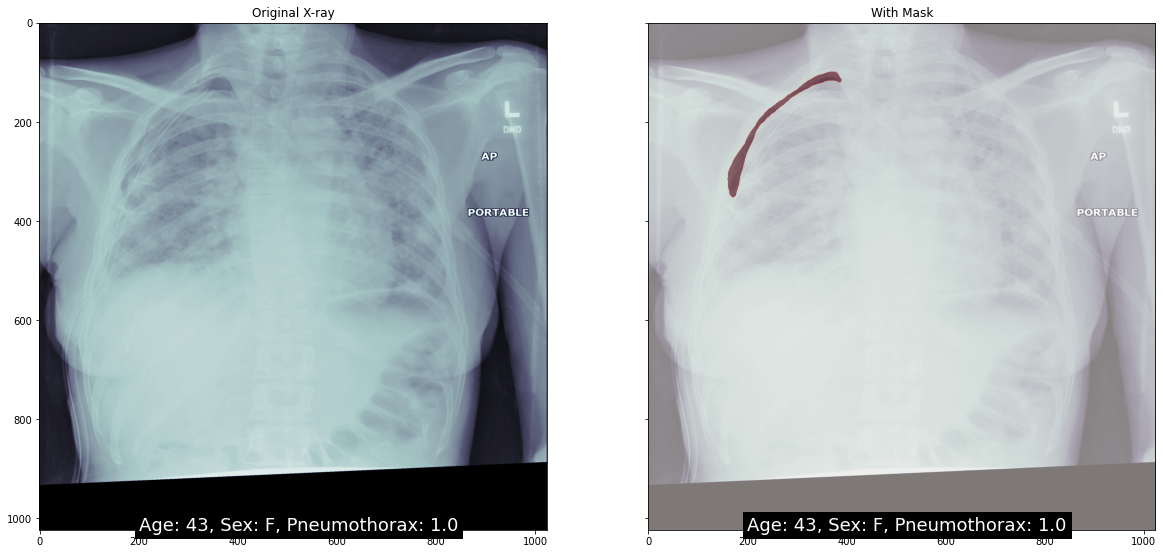

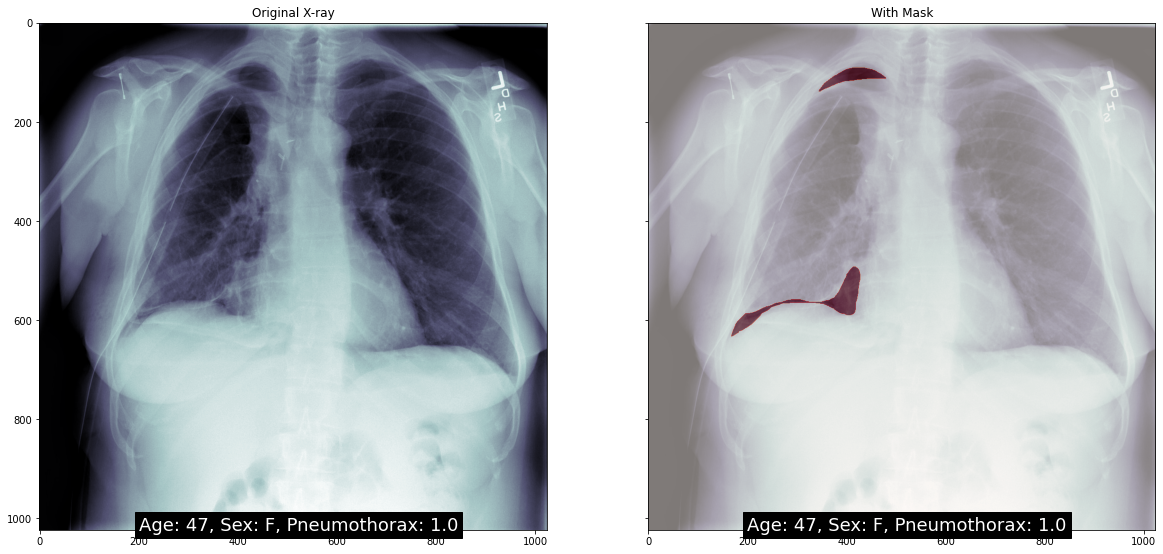

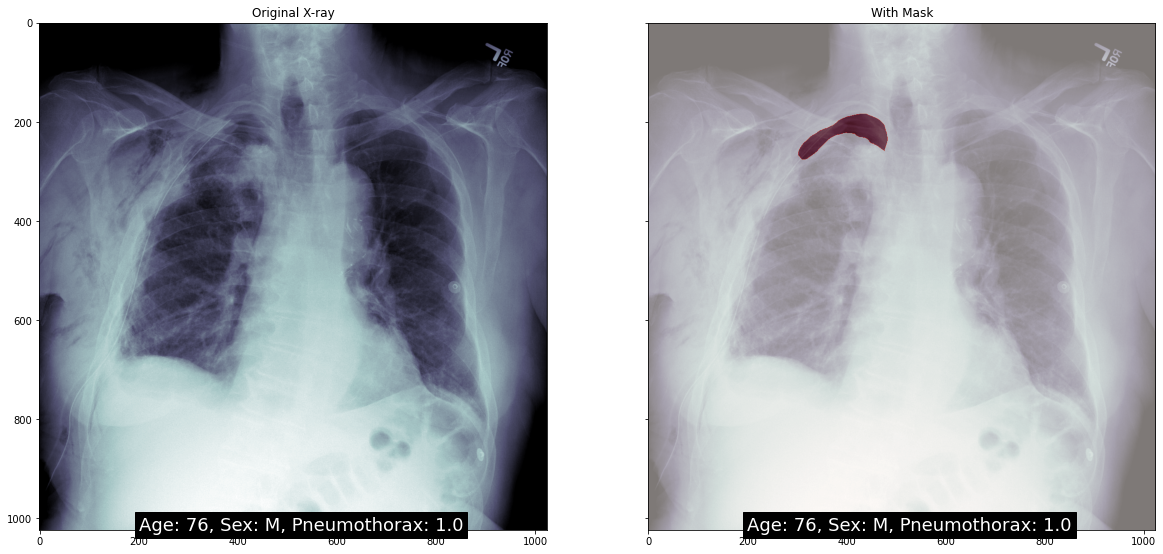

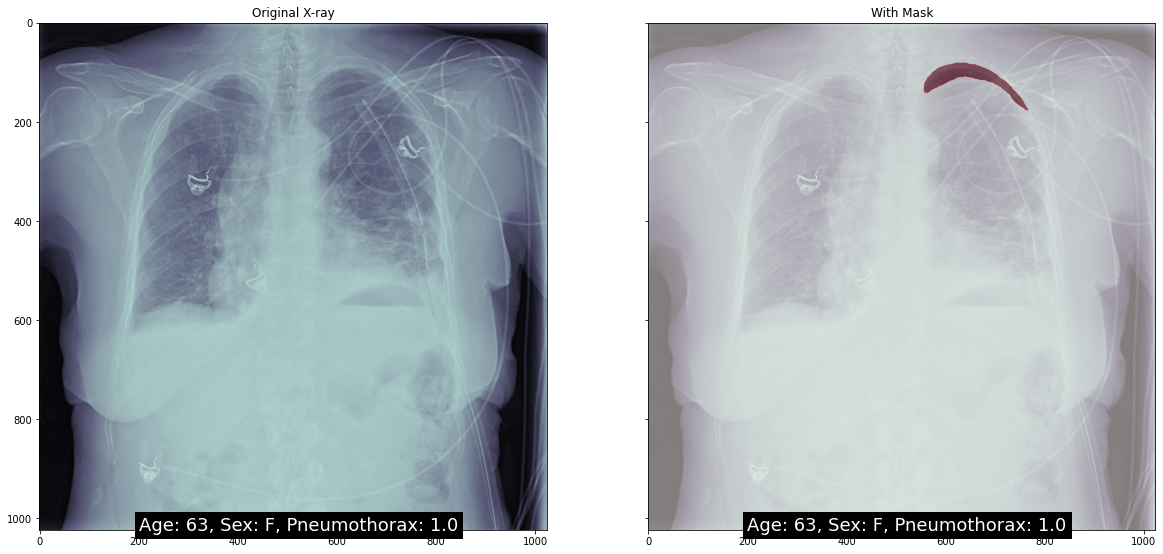

In [24]:
plot_training_images(samples)

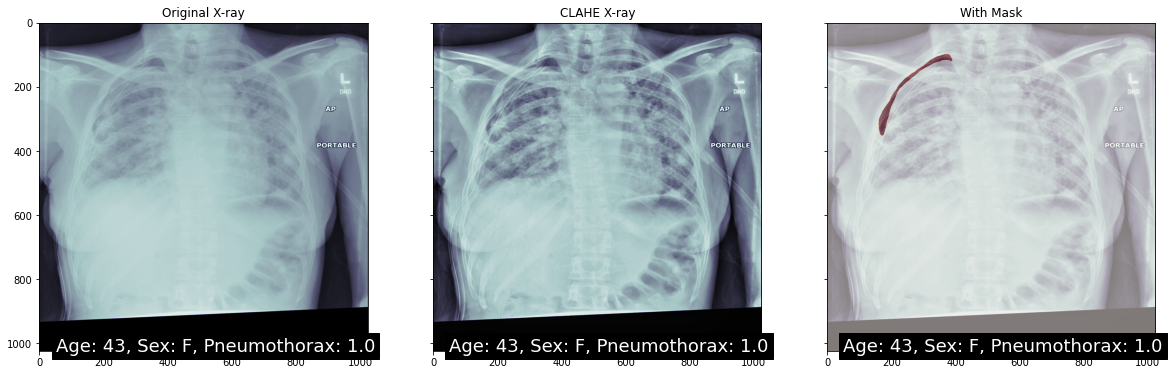

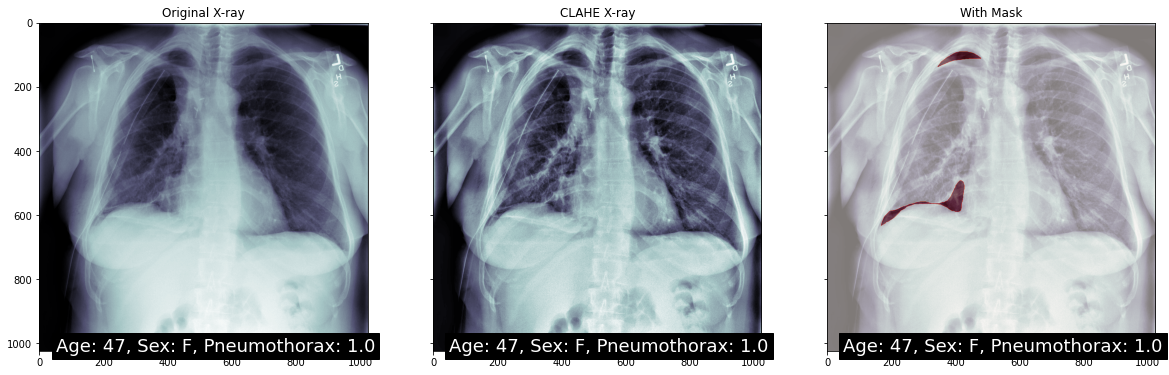

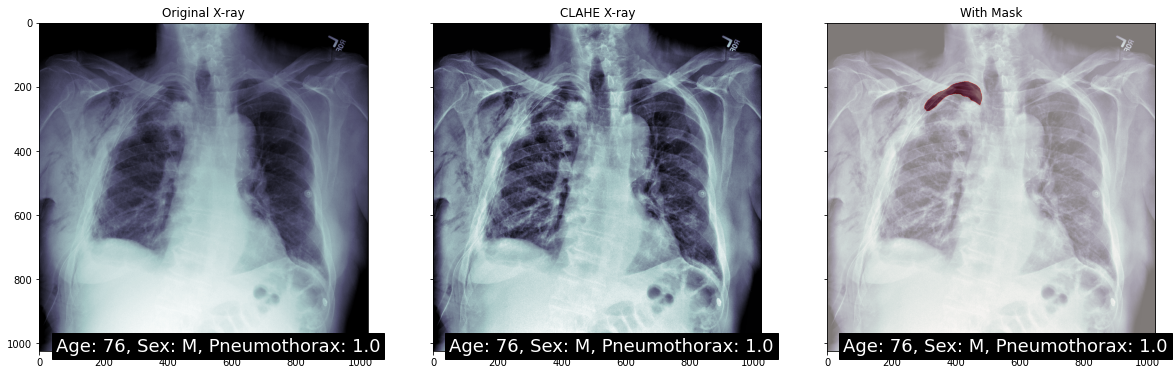

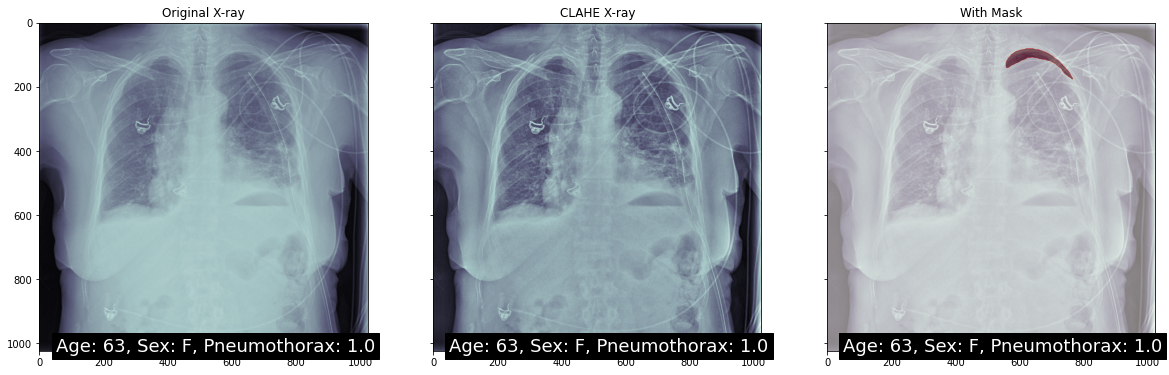

In [25]:
plot_training_images_CLAHE(samples)

# EDA

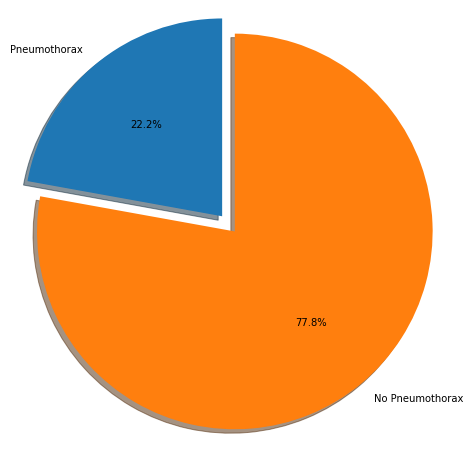

In [17]:
# Label analysis
labels = ['Pneumothorax', 'No Pneumothorax']
pos = len(train_dataset[train_dataset.has_pneumothorax == 1])
neg = len(train_dataset) - pos
sizes = [pos, neg]
explode = (0.1, 0)

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

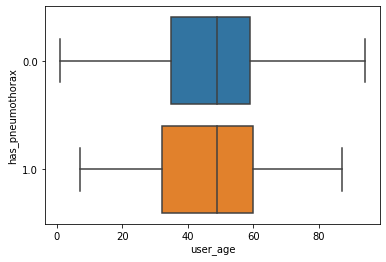

In [18]:
# Box-plot ages
train_dataset = train_dataset[train_dataset.user_age <= 100] # remove outliers
ax = sns.boxplot(x="user_age", y="has_pneumothorax", data=train_dataset, orient="h")

In [19]:
# Discrete ages
def age_categories(age):
    # take age as input and return age category
    if age <= 14:
        return 'Child'
    if age >= 15 and age <= 24:
        return 'Youth'
    if age >= 25 and age <= 64:
        return 'Adult'
    if age >= 65:
        return 'Senior'

# get age categories
train_dataset['age_category'] = train_dataset['user_age'].apply(age_categories)

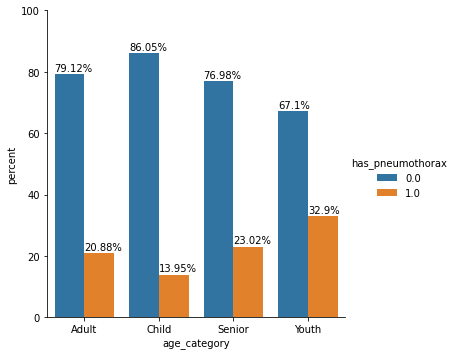

In [20]:
# M-F analysis
x, y = 'age_category', 'has_pneumothorax'
df1 = train_dataset.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height() + 1
    g.ax.text(txt_x, txt_y, txt)

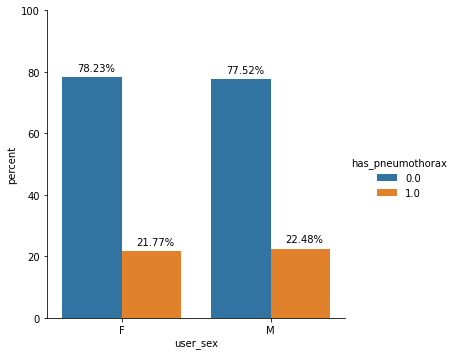

In [21]:
# M-F analysis
x, y = 'user_sex', 'has_pneumothorax'
df1 = train_dataset.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() + .1
    txt_y = p.get_height() + 2
    g.ax.text(txt_x, txt_y, txt)

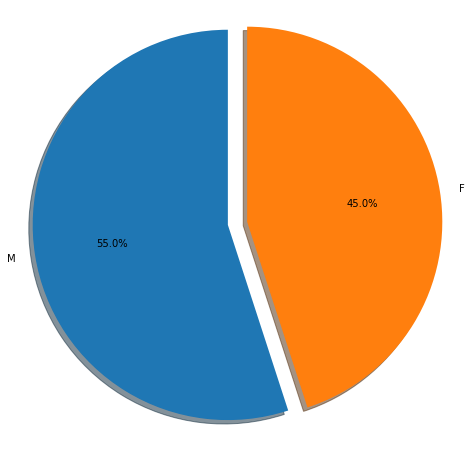

In [22]:
labels = ['M', 'F']
pos = len(train_dataset[train_dataset.user_sex == "M"])
neg = len(train_dataset[train_dataset.user_sex == "F"])
sizes = [pos, neg]
explode = (0.1, 0)

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()